In [1]:
from dotalytics.pipeline import *
%matplotlib inline

In [24]:
## Retrieving a missing hero names and roles information from the API.

r = requests.get('https://api.opendota.com/api/heroes')
hero_list = json.loads(r.text)

## Saving the API info as a dataframe

hero_df = pd.DataFrame(hero_list)
hero_df.drop(['name','primary_attr','legs'],axis=1,inplace = True)

In [25]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[2]')
         .appName('capstone')
         .getOrCreate()
        )

In [26]:
samples_eda = spark.read.csv('players_larger_sample.csv',
                             header = True,
                             sep=',',
                             inferSchema=True)

In [27]:
df_players_samples_eda = samples_eda.select('hero_id','kills','deaths')
df_players_samples_eda.show(5)

+-------+-----+------+
|hero_id|kills|deaths|
+-------+-----+------+
|     14|   19|     8|
|     32|    5|     2|
|    100|    7|    19|
|     76|    7|    10|
|     86|   11|     5|
+-------+-----+------+
only showing top 5 rows



In [28]:
## Querying average stats by playable characters

df_players_samples_eda.createOrReplaceTempView("stats")

query = """
SELECT 
    hero_id,
    COUNT(hero_id) as freq
FROM stats s
GROUP BY hero_id
ORDER BY freq DESC 
"""

popularity_query = spark.sql(query)

In [29]:
## Adding a percentage column for characters

popularity_query = popularity_query.withColumn('percent',func.col('freq')/func.sum('freq').over(Window.partitionBy()))

In [30]:
## Exporting the mean values to pandas 

pd_popularity = popularity_query.toPandas()

In [31]:
pd_popularity['percent'] = pd_popularity['percent'].apply(lambda x: f'{float(x):.3f}')

In [32]:
hero_df.head(1)

,id,localized_name,attack_type,roles
0,1,Anti-Mage,Melee,"[Carry, Escape, Nuker]"


In [33]:
## Removing the hero_id: 0, since it is not available from the API

pd_popularity.drop(index=60,inplace = True)

In [34]:
## Resetting the index

pd_popularity.reset_index(drop = True, inplace = True)

In [46]:
## Separating the roles

df_chars = pd.merge(pd_popularity,
                        hero_df,
                        left_on = 'hero_id',
                        right_on = 'id',
                        how = 'inner')\
                            .drop('id',axis=1)

In [47]:
## Converting a number of object columns into numeric columns

cols = ['freq', 'percent']

df_chars[cols] = df_chars[cols].apply(pd.to_numeric, errors = 'coerce')


## Rearranging columns for better legibility

cols_re = ['hero_id','localized_name','roles','freq','percent']

df_chars = df_chars[cols_re]

df_chars['popularity'] = df_chars['freq'].rank(ascending = False)

In [50]:
df_chars.head(5)

,hero_id,localized_name,roles,freq,percent,popularity
0,14,Pudge,"[Disabler, Initiator, Durable, Nuker]",35634,0.031,1.0
1,35,Sniper,"[Carry, Nuker]",30918,0.027,2.0
2,6,Drow Ranger,"[Carry, Disabler, Pusher]",28480,0.025,3.0
3,32,Riki,"[Carry, Escape, Disabler]",24722,0.022,4.0
4,44,Phantom Assassin,"[Carry, Escape]",24605,0.022,5.0


Out of a million sample data points, 144359 players had chosen to play as the above 5 characters. Let's see if we can find any statistical significance between the above 5 characters and the rest.

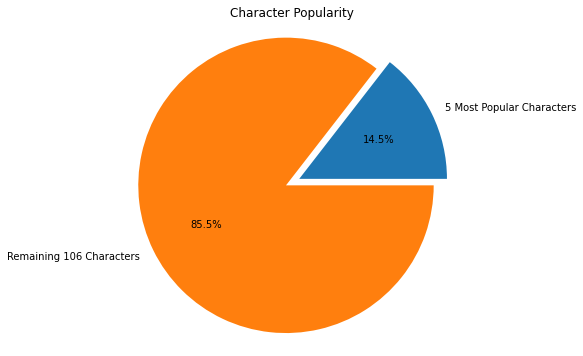

In [38]:
fig,ax = plt.subplots(figsize=(10,6))

labels = ['5 Most Popular Characters', 'Remaining 106 Characters']
explode = (0.1,0)
sizes = [0.38, 0.62]

ax.pie([df_chars.loc[:5]['percent'].sum(), df_chars.loc[5:]['percent'].sum()],
      explode = explode,
      labels = labels,
      startangle = 0,
      autopct = '%1.1f%%')

ax.axis('equal')
ax.set_title('Character Popularity')

plt.show()

## Going back to the raw data for hypothesis testing

Null Hypothesis ${H_0}$: Choosing one of the five most popular characters does not affect the number of kills per match.


Alternate Hypothesis $H_A$: Choosing one of the five most popular characters increases the chance of scoring additional kills per match.

In [39]:
## Using the sample data to plot distributions
df_full = df_players_samples_eda.toPandas()

In [40]:
top5_ids = df_chars.iloc[:5]['hero_id']
df_top5 = df_full[df_full['hero_id'].isin(top5_ids)]
df_rest = df_full[~df_full['hero_id'].isin(top5_ids)]

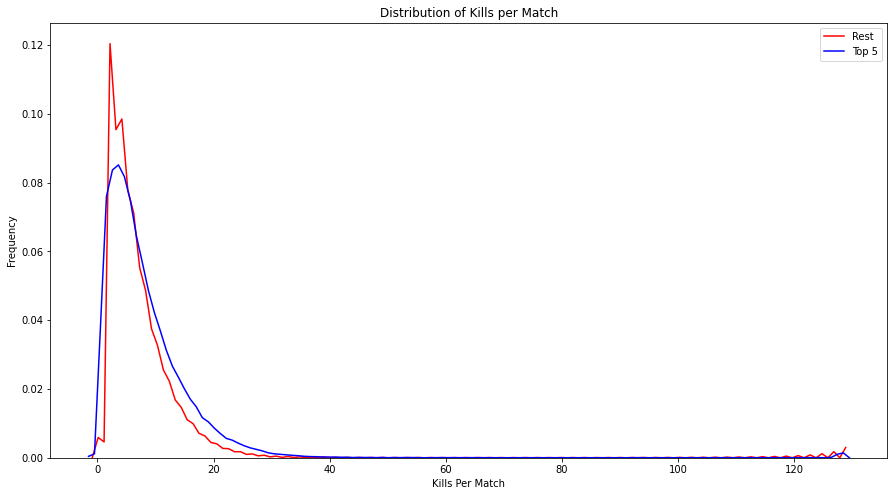

In [41]:
fig,ax = plt.subplots(figsize = (15,8))

ax = sns.distplot(df_rest['kills'], hist = False, kde_kws = {'color': 'red'}, label = 'Rest')
ax = sns.distplot(df_top5['kills'], hist = False, kde_kws = {'color': 'blue'}, label = 'Top 5') 

ax.set_title('Distribution of Kills per Match')

ax.set_xlabel('Kills Per Match')

ax.set_ylabel('Frequency')

ax.legend()

plt.show()

The mean of the kills/match for the top 5: 7.8209256090718275
The standard deviation of the kills/match for the top 5: 7.8209256090718275

The mean of the kills/match for the rest of the characters: 5.691196788667019
The standard deviation of the kills/match for the rest: 5.258115650462181


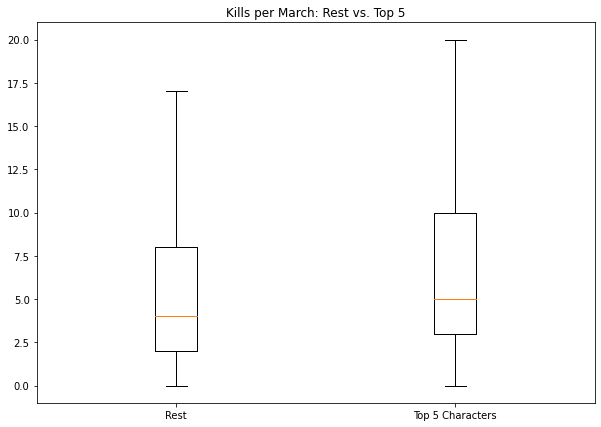

In [42]:
rest_processed = subset_by_iqr(df_rest,'kills')
top5_processed = subset_by_iqr(df_top5,'kills')

rest_mean = np.mean(df_rest['kills'])
top_mean = np.mean(df_top5['kills'])

rest_std = np.std(df_rest['kills'])
top_std = np.std(df_top5['kills'])

plt,ax = plt.subplots(1, figsize = (10,7))

ax.boxplot([rest_processed,top5_processed])

ax.set_xticks([1,2])
ax.set_xticklabels(["Rest","Top 5 Characters"])
ax.set_title("Kills per March: Rest vs. Top 5" )

plt.show()

print(f'The mean of the kills/match for the top 5: {top_mean}')
print(f'The standard deviation of the kills/match for the top 5: {top_mean}')
print()
print(f'The mean of the kills/match for the rest of the characters: {rest_mean}')
print(f'The standard deviation of the kills/match for the rest: {rest_std}')

In [43]:
stats, pval = stats.ttest_ind(df_top5['kills'],df_rest['kills'],equal_var=False)
print(f'The p-value from the Welch T test is: {pval}')

The p-value from the Welch T test is: 0.0


The Welch's t-test and the Student's t-test assume that both sample groups have normal distributions. As per the Law of large numbers and the fact that I am dealing with a million data points, I can assume that the samples I am working with would be normally distributed. However, I cannot  assume that the variance would be similar from both sample groups. does not appear to be significantly large, but the p-value from the Welch's t-test indicates that the difference in fact is statistically significant.

In [44]:
# Performing a non-parametric test: Mann-Whitney Signed Rank Test for feature: kills
import scipy.stats as stats
res = stats.mannwhitneyu(df_top5,df_rest, alternative = 'two-sided')
res

MannwhitneyuResult(statistic=241295586053.0, pvalue=0.0)

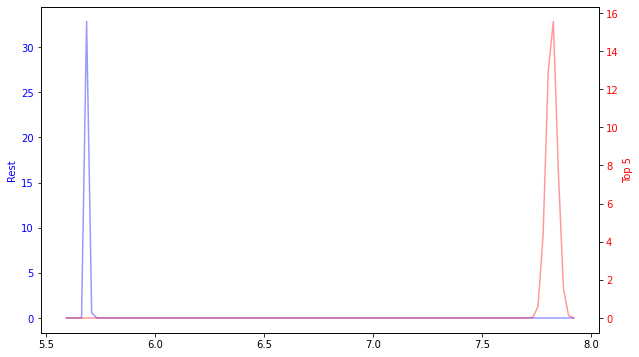

95% confidence interval for top 5: [7.772530431853918, 7.869320786289737]
95% confidence interval for the rest: [5.680862498892597, 5.701531078441442]


In [54]:
y1 = stats.norm(np.mean(df_top5['kills']),np.std(df_top5['kills'])/np.sqrt(len(df_top5)))
#y2 = stats.norm(np.mean(df_top5['kills']),np.std(df_top5['kills']))
y3 = stats.norm(np.mean(df_rest['kills']),np.std(df_rest['kills'])/np.sqrt(len(df_rest)))

x = np.linspace(np.mean(df_rest['kills'])-0.1,np.mean(df_top5['kills'])+0.1, 101)

left_ci_t, right_ci_t = y1.ppf(0.025), y1.ppf(0.975)
left_ci_r, right_ci_r = y3.ppf(0.025), y3.ppf(0.975)

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

ax1.plot(x, y3.pdf(x), c='blue', alpha = 0.4)
ax2.plot(x, y1.pdf(x), c = 'red', alpha = 0.4)

ax1.set_ylabel('Rest', c = 'blue')
ax1.tick_params(axis= 'y', labelcolor = 'blue')
#ax1.fill_between(x,y3, c = 'blue')

ax2.set_ylabel('Top 5', c = 'red')
ax2.tick_params(axis='y',labelcolor = 'red')

ax1.grid(False)
ax2.grid(False)

plt.show()

print(f'95% confidence interval for top 5: [{left_ci_t}, {right_ci_t}]')
print(f'95% confidence interval for the rest: [{left_ci_r}, {right_ci_r}]')